# Mobility indicators
## Assessing the impact of mobility restrictions during a virus outbreak

In this worked example...

(Include link to COVID website)

### Introduction

- What we aim to do
- Summary of where we're heading, what prior knowledge is required, and what the end result will be

### Run aggregates

- Define queries
- Set aggregates running
- Get results

In [81]:
import flowclient as fc
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import Counter

In [82]:
token = 

In [83]:
conn = fc.connect(
    url="https://api.flowcloud-ghana.flowminder.org",
    token=token,
)

In [108]:
# Define date range
start_date = "2016-02-01"
end_date = "2016-06-01"
all_dates = pd.date_range(start_date, end_date, closed="left")

In [85]:
# Total subscribers per day

# E.g. query for 1 day
total_subscribers_20160101_query = fc.unique_subscriber_counts(
    connection=conn,
    start_date="2016-01-01",
    end_date="2016-01-02",
    aggregation_unit="admin0",
)

# Queries for all dates
total_subscribers_per_day_queries = {}

for day in all_dates:
    total_subscribers_per_day_queries[day] = fc.unique_subscriber_counts(
        connection=conn,
        start_date=str(day),
        end_date=str(day + pd.Timedelta("1 day")),
        aggregation_unit="admin0",
    )

In [86]:
# Set them running
for query in total_subscribers_per_day_queries.values():
    query.run()

In [87]:
# Subscribers per admin1 per day
subscribers_per_admin1_per_day_queries = {
    day: fc.unique_subscriber_counts(
        connection=conn,
        start_date=str(day),
        end_date=str(day + pd.Timedelta("1 day")),
        aggregation_unit="admin1",
    )
    for day in all_dates
}

for query in subscribers_per_admin1_per_day_queries.values():
    query.run()

In [146]:
# Subscribers per admin2 per day
subscribers_per_admin2_per_day_queries = {
    day: fc.unique_subscriber_counts(
        connection=conn,
        start_date=str(day),
        end_date=str(day + pd.Timedelta("1 day")),
        aggregation_unit="admin2",
    )
    for day in all_dates
}

for query in subscribers_per_admin2_per_day_queries.values():
    query.run()

In [89]:
# OD matrix (admin2)
od_matrix_admin2_per_day_queries = {
    day: fc.trips_od_matrix(
        connection=conn,
        start_date=str(day),
        end_date=str(day + pd.Timedelta("1 day")),
        aggregation_unit="admin2",
    )
    for day in all_dates
}

for query in od_matrix_admin2_per_day_queries.values():
    query.run()

In [111]:
# Total events per day

total_events_per_day_query = fc.location_event_counts(
    connection=conn,
    start_date=start_date,
    end_date=end_date,
    count_interval="day",
    aggregation_unit="admin0",
)

total_events_per_day_query.run()

In [112]:
# Event counts (admin2 per day)
events_per_admin2_per_day_query = fc.location_event_counts(
    connection=conn,
    start_date=start_date,
    end_date=end_date,
    count_interval="day",
    aggregation_unit="admin2",
)

events_per_admin2_per_day_query.run()

In [147]:
# Check statuses
for label, query_group in [
    ("Total subscribers", total_subscribers_per_day_queries),
    ("Subscribers per admin1", subscribers_per_admin1_per_day_queries),
    ("Subscribers_per_admin2", subscribers_per_admin2_per_day_queries),
    ("OD matrix", od_matrix_admin2_per_day_queries),
]:
    print(
        f"{label}: {Counter([query.status for query in query_group.values()])}"
    )

print(f"Total events: {total_events_per_day_query.status}")
print(f"Events per admin2: {events_per_admin2_per_day_query.status}")

Total subscribers: Counter({'completed': 121})
Subscribers per admin1: Counter({'completed': 121})


FlowclientConnectionError: Something went wrong: . API returned with status code: 500 and status 'errored'

In [93]:
# Get results

# Get one result
first_result = total_subscribers_per_day_queries[all_dates[0]].get_result()
first_result

,pcod,value
0,GH,2136902


In [94]:
# Add date column
first_result["date"] = all_dates[0]
first_result

,pcod,value,date
0,GH,2136902,2016-02-01


In [95]:
# Get all results with date columns
all_total_subscribers_results = [
    query.get_result().assign(date=day)
    for day, query in total_subscribers_per_day_queries.items()
]

total_subscribers_per_day_results = pd.concat(all_total_subscribers_results, ignore_index=True)

total_subscribers_per_day_results

,pcod,value,date
0,GH,2136902,2016-02-01
1,GH,2136917,2016-02-02
2,GH,2138207,2016-02-03
3,GH,2136691,2016-02-04
4,GH,2137545,2016-02-05
...,...,...,...
116,GH,2136774,2016-05-27
117,GH,2137298,2016-05-28
118,GH,2137551,2016-05-29
119,GH,2137748,2016-05-30


In [157]:
# Don't need "pcod" column, so let's drop it now
total_subscribers_per_day_results = total_subscribers_per_day_results.drop(columns="pcod")
total_subscribers_per_day_results

,value,date
0,2136902,2016-02-01
1,2136917,2016-02-02
2,2138207,2016-02-03
3,2136691,2016-02-04
4,2137545,2016-02-05
...,...,...
116,2136774,2016-05-27
117,2137298,2016-05-28
118,2137551,2016-05-29
119,2137748,2016-05-30


In [96]:
# Get admin1 subscriber counts
subscribers_per_admin1_per_day_results = pd.concat(
    [
        query.get_result().assign(date=day)
        for day, query in subscribers_per_admin1_per_day_queries.items()
    ],
    ignore_index=True,
)

subscribers_per_admin1_per_day_results

,pcod,value,date
0,GHA.10_1,227680,2016-02-01
1,GHA.1_1,470141,2016-02-01
2,GHA.2_1,204697,2016-02-01
3,GHA.3_1,222221,2016-02-01
4,GHA.4_1,246779,2016-02-01
...,...,...,...
1205,GHA.5_1,455908,2016-05-31
1206,GHA.6_1,299673,2016-05-31
1207,GHA.7_1,117576,2016-05-31
1208,GHA.8_1,72302,2016-05-31


In [ ]:
# Get admin2 subscriber counts
subscribers_per_admin2_per_day_results = pd.concat(
    [
        query.get_result().assign(date=day)
        for day, query in subscribers_per_admin2_per_day_queries.items()
    ],
    ignore_index=True,
)

subscribers_per_admin2_per_day_results

In [ ]:
# Get admin2 OD matrix results
od_matrix_admin2_per_day_results = pd.concat(
    [
        query.get_result().assign(date=day)
        for day, query in od_matrix_admin2_per_day_queries.items()
    ],
    ignore_index=True,
)

od_matrix_admin2_per_day_results

In [ ]:
# Get total event counts
total_events_per_day_results = total_events_per_day_query.get_result()

# Don't need to add a date column because it already has one, but...
total_events_per_day_results.info()

In [ ]:
# Date column is 'object' type (i.e. string) - need to convert to datetime
total_events_per_day_results["date"] = pd.to_datetime(total_events_per_day_results["date"])

total_events_per_day_results

In [121]:
# Get admin2 event counts
events_per_admin2_per_day_results = events_per_admin2_per_day_query.get_result()
events_per_admin2_per_day_results["date"] = pd.to_datetime(events_per_admin2_per_day_results["date"])

events_per_admin2_per_day_results

,pcod,date,value
0,GHA.10.10_1,2016-02-01,136114
1,GHA.10.1_1,2016-02-01,28901
2,GHA.10.11_1,2016-02-01,18318
3,GHA.10.12_1,2016-02-01,29705
4,GHA.10.13_1,2016-02-01,47380
...,...,...,...
16500,GHA.9.5_1,2016-05-31,31992
16501,GHA.9.6_1,2016-05-31,13468
16502,GHA.9.7_1,2016-05-31,34588
16503,GHA.9.8_1,2016-05-31,53798


### QA checks

- Additional queries (define, run, get results)
- Run checks
    - Subscriber counts in urban vs rural
    - sum(admin2 counts) / admin1 count ? (Maybe not - this might be an indicator)
    - Stable over time (total, and per locality)
    - Weekly variation (except there won't actually be any in the synthetic data)
    - Events per subscriber - check sensible value and stable over time
    - Missing data (temporal or spatial)
- Explain results (and how to tell whether they 'passed')

**Note:** Don't need all checks, because some are covered by FlowKit tests (i.e. we need to QA check the data, not the implementation)

#### Time-series plots
Should be stable over time and show weekly variation

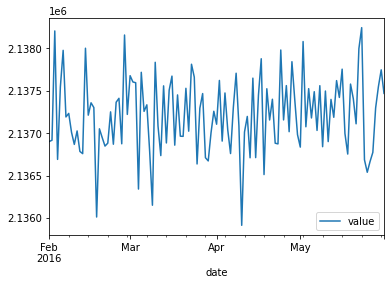

In [98]:
total_subscribers_per_day_results.plot(x="date", y="value")

- Should be stable over time except for possible small changes due to new mobility restrictions
- Should show weekly variation (but not in the synthetic data)

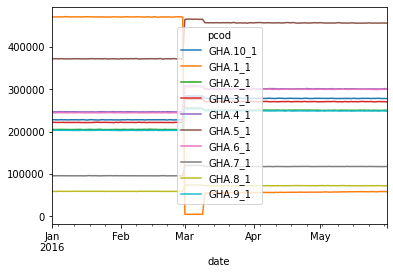

In [63]:
subscribers_per_admin1_per_day_results.pivot(index="date", columns="pcod", values="value").plot()

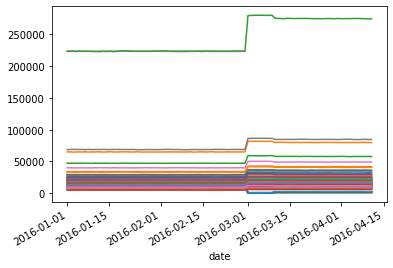

In [142]:
subscribers_per_admin2_per_day_results.pivot(index="date", columns="pcod", values="value").plot(legend=False)

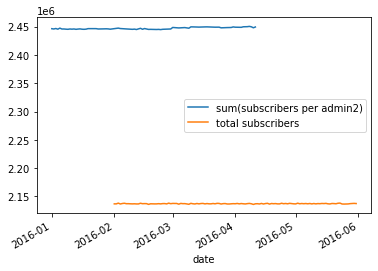

In [152]:
# May be clearer to plot sum
plt.figure()
subscribers_per_admin2_per_day_results.groupby("date").sum().plot(ax=plt.gca(), y="value", label="sum(subscribers per admin2)")

# Similar for OD matrix
od_matrix_admin2_per_day_results.groupby("date").sum().plot(ax=plt.gca(), y="value", label="sum(OD matrix)")

# Show total subscribers for comparison
total_subscribers_per_day_results.plot(ax=plt.gca(), x="date", y="value", label="total subscribers")

- Should be stable over time except for changes due to new mobility restrictions (in this case, sharp changes are due to start of simulated "disaster" on 2016-03-01 and start of recovery period on 2016-03-10)
- Should show weekly variation (but not in the synthetic data)
- Explain why sum of admin2 is larger than total

#### Spatial distribution of subscriber counts
Should be larger in urban districts, smaller in rural

In [ ]:
# Calculate median daily subscriber count per admin2
median_subscribers_per_admin2 = subscribers_per_admin2_per_day_results.groupby("pcod").median()

In [65]:
# Get admin2 boundaries
admin2_geojson = fc.get_geography(connection=conn, aggregation_unit="admin2")
admin2_gdf = gpd.GeoDataFrame.from_features(admin2_geojson)
admin2_gdf

,geometry,pcod,centroid
0,"MULTIPOLYGON (((-1.41637 6.32333, -1.43242 6.3...",GHA.1.1_1,"{'type': 'Point', 'coordinates': [-1.585607706..."
1,"MULTIPOLYGON (((-1.54145 5.93492, -1.53550 5.9...",GHA.1.2_1,"{'type': 'Point', 'coordinates': [-1.394701237..."
2,"MULTIPOLYGON (((-1.41025 6.86558, -1.42795 6.8...",GHA.1.3_1,"{'type': 'Point', 'coordinates': [-1.557937016..."
3,"MULTIPOLYGON (((-2.29597 6.71882, -2.29462 6.7...",GHA.1.4_1,"{'type': 'Point', 'coordinates': [-2.201639978..."
4,"MULTIPOLYGON (((-1.81879 6.98329, -1.83513 6.9...",GHA.1.5_1,"{'type': 'Point', 'coordinates': [-1.957634046..."
...,...,...,...
132,"MULTIPOLYGON (((-2.36110 6.08630, -2.36740 6.0...",GHA.10.9_1,"{'type': 'Point', 'coordinates': [-2.609585309..."
133,"MULTIPOLYGON (((-1.82511 5.57554, -1.82662 5.5...",GHA.10.11_1,"{'type': 'Point', 'coordinates': [-2.009582598..."
134,"MULTIPOLYGON (((-1.70347 4.94569, -1.70347 4.9...",GHA.10.10_1,"{'type': 'Point', 'coordinates': [-1.658353642..."
135,"MULTIPOLYGON (((-2.59935 5.44091, -2.59728 5.4...",GHA.10.12_1,"{'type': 'Point', 'coordinates': [-2.332295004..."


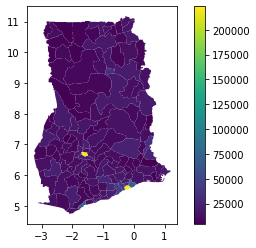

In [68]:
# Join median subscriber counts to admin boundaries, and plot
median_subscribers_per_admin2_with_geo = admin2_gdf.merge(
    median_subscribers_per_admin2, left_on="pcod", right_index=True
)

median_subscribers_per_admin2_with_geo.plot(column="value", legend=True)

- Should have larger subscriber counts in urban districts, and smaller in rural districts

#### Events per subscriber (for each admin2, then for whole country)

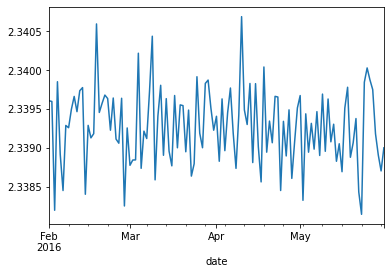

In [124]:
# Total events per day
average_events_per_subscriber = total_events_per_day_results.set_index("date").value / total_subscribers_per_day_results.set_index("date").value

average_events_per_subscriber.plot()

- Values should be reasonable (e.g. not 500 events per subscriber per day)
- Values should be >= 1 (because every active subscriber has at least 1 event
- Values should be fairly stable over time

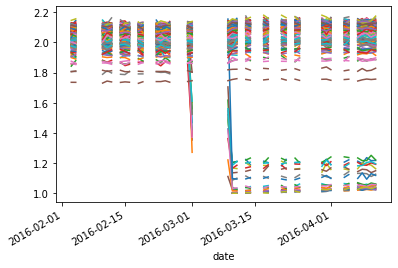

In [141]:
# Per admin2
events_per_subscriber_per_admin2 = (
    events_per_admin2_per_day_results.set_index(["date", "pcod"]) / subscribers_per_admin2_per_day_results.set_index(["date", "pcod"])
).reset_index()
events_per_subscriber_per_admin2.pivot(index="date", columns="pcod", values="value").plot(legend=False)

#### Missing data
- Total events per day, over time

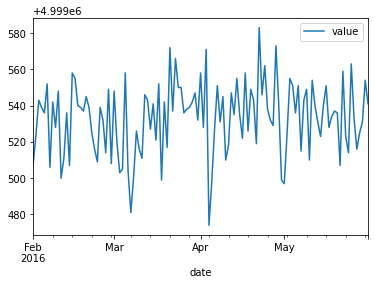

In [135]:
total_events_per_day_results.plot(x="date", y="value")

- If there's an anomaly, show a map of events per admin2 on that day, to see if there's a spatial effect

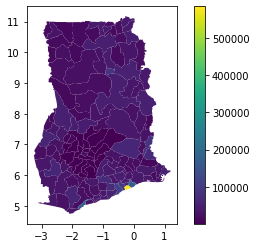

In [156]:
# E.g. if total event count was lower on 13 March, can plot event count per admin2 on that day
admin2_gdf.merge(
    events_per_admin2_per_day_results[events_per_admin2_per_day_results.date == "2016-03-14"],
    on="pcod",
).plot(column="value", legend=True)

If no data for parts of the country, suggests the CDR data are incomplete.

### Indicators

- Calculate indicators from aggregates
    - Scaled subscriber count per admin2 (including baseline calculation)
    - Average admin2 visited per subscriber for each admin1
    - Scaled OD matrix subscriber count
- Produce visualisations (not sure exactly what to show for OD matrix - maybe pick a few pairs and show line plots; could also do a before vs after map of Accra -> other)
- Explain what we see

#### Scaled subscriber count per admin2

- Divide subscriber count by total, to mitigate effects of changes in calling behaviour (i.e. assume actual number of people is ~ constant, so changes in total are due to people calling more/less)
- Calculate baseline average
- % of baseline

In [181]:
# Merge admin2 and total subscribers
merged_subscriber_counts = subscribers_per_admin2_per_day_results.merge(
    total_subscribers_per_day_results.rename(columns={"value": "total_subscribers"}), on="date"
)

# Divide sub count by total subs to get scaled sub count
merged_subscriber_counts["scaled_subscriber_count"] = (
    merged_subscriber_counts.value / merged_subscriber_counts.total_subscribers
)

merged_subscriber_counts

,pcod,value,date,total_subscribers,scaled_subscriber_count
0,GHA.10.10_1,64982,2016-02-03,2138207,0.030391
1,GHA.10.1_1,13868,2016-02-03,2138207,0.006486
2,GHA.10.11_1,8934,2016-02-03,2138207,0.004178
3,GHA.10.12_1,14485,2016-02-03,2138207,0.006774
4,GHA.10.13_1,22758,2016-02-03,2138207,0.010643
...,...,...,...,...,...
5580,GHA.9.5_1,15398,2016-04-11,2137014,0.007205
5581,GHA.9.6_1,6403,2016-04-11,2137014,0.002996
5582,GHA.9.7_1,16460,2016-04-11,2137014,0.007702
5583,GHA.9.8_1,25406,2016-04-11,2137014,0.011889


In [182]:
# Baseline median
baseline_start = "2016-02-01"
baseline_end = "2016-02-29"

scaled_subscriber_count_baseline = merged_subscriber_counts[
    (merged_subscriber_counts.date >= baseline_start)
    & (merged_subscriber_counts.date < baseline_end)
].groupby("pcod").median().scaled_subscriber_count
scaled_subscriber_count_baseline

pcod
GHA.1.10_1    0.004650
GHA.1.11_1    0.009366
GHA.1.12_1    0.005379
GHA.1.13_1    0.011214
GHA.1.14_1    0.006864
                ...   
GHA.9.5_1     0.005901
GHA.9.6_1     0.002443
GHA.9.7_1     0.006250
GHA.9.8_1     0.009675
GHA.9.9_1     0.004555
Name: scaled_subscriber_count, Length: 137, dtype: float64

In [183]:
merged_subscriber_counts = merged_subscriber_counts.merge(
    scaled_subscriber_count_baseline,
    left_on="pcod",
    right_index=True,
    suffixes=("", "_baseline")
)

merged_subscriber_counts

,pcod,value,date,total_subscribers,scaled_subscriber_count,scaled_subscriber_count_baseline
0,GHA.10.10_1,64982,2016-02-03,2138207,0.030391,0.030399
137,GHA.10.10_1,65110,2016-02-04,2136691,0.030472,0.030399
274,GHA.10.10_1,64911,2016-02-07,2137192,0.030372,0.030399
411,GHA.10.10_1,64948,2016-02-10,2136868,0.030394,0.030399
548,GHA.10.10_1,65159,2016-02-11,2137027,0.030490,0.030399
...,...,...,...,...,...,...
5036,GHA.9.9_1,11812,2016-04-07,2137304,0.005527,0.004555
5173,GHA.9.9_1,11796,2016-04-08,2137708,0.005518,0.004555
5310,GHA.9.9_1,11770,2016-04-09,2137087,0.005507,0.004555
5447,GHA.9.9_1,11864,2016-04-10,2135913,0.005555,0.004555


In [184]:
merged_subscriber_counts["percent_change"] = (
    merged_subscriber_counts.scaled_subscriber_count / merged_subscriber_counts.scaled_subscriber_count_baseline - 1
) * 100
merged_subscriber_counts

,pcod,value,date,total_subscribers,scaled_subscriber_count,scaled_subscriber_count_baseline,percent_change
0,GHA.10.10_1,64982,2016-02-03,2138207,0.030391,0.030399,-0.027144
137,GHA.10.10_1,65110,2016-02-04,2136691,0.030472,0.030399,0.240851
274,GHA.10.10_1,64911,2016-02-07,2137192,0.030372,0.030399,-0.088948
411,GHA.10.10_1,64948,2016-02-10,2136868,0.030394,0.030399,-0.016840
548,GHA.10.10_1,65159,2016-02-11,2137027,0.030490,0.030399,0.300517
...,...,...,...,...,...,...,...
5036,GHA.9.9_1,11812,2016-04-07,2137304,0.005527,0.004555,21.333545
5173,GHA.9.9_1,11796,2016-04-08,2137708,0.005518,0.004555,21.146293
5310,GHA.9.9_1,11770,2016-04-09,2137087,0.005507,0.004555,20.914395
5447,GHA.9.9_1,11864,2016-04-10,2135913,0.005555,0.004555,21.947058


(-100.0, 31.561113800097285)

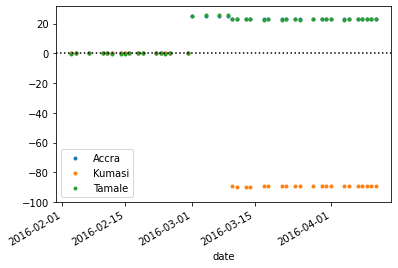

In [190]:
# Choose a few districts to show
display_districts = {
    "Accra": "GHA.5.1_1",
    "Kumasi": "GHA.1.16_1",
    "Tamale": "GHA.6.13_1",
}

# Plot % change over time for the chosen districts
plt.figure()
for name, pcod in display_districts.items():
    merged_subscriber_counts[merged_subscriber_counts.pcod == pcod].plot(
        ax=plt.gca(), x="date", y="percent_change", marker=".", ls="", label=name
    )
plt.axhline(0, ls=":", c='k')
plt.ylim(bottom=-100)

#### Average admin2 per subscriber in each admin1

- Add admin1 pcode column to admin2 counts
- Sum admin2 counts per admin1
- Join to admin1 counts
- Divide
- Plot over time for all admin1 regions

#### Scaled OD matrix counts
- Same process as for scaled admin2 counts
- Show a map of before vs after for either Accra or Kumasi (not sure which will look better)

### Summary

- What we did
- What it showed
- Maybe some advice on how this could be modified to do other things